# Exploratory Data Analysis - 2005 Moscow Blackout Incident

## Description of the Selected Features

The following features have been extracted from the BGP (Border Gateway Protocol) update messages contained in RIPE RIS MRT dumps and processed in configurable time windows:

1. **Feature 0: Total Number of BGP Update Messages**  
   - **Description**: The total count of all BGP update messages (both announcements and withdrawals) observed within each time window.  
   - **Use Case**: Provides a baseline measure of routing activity over time.  

2. **Feature 1: Number of BGP ANNOUNCEMENT Messages**  
   - **Description**: The total count of BGP `ANNOUNCEMENT` messages observed within each time window.  
   - **Use Case**: Tracks the frequency of new route announcements, indicating changes or additions in routing information.  

3. **Feature 2: Number of BGP WITHDRAWAL Messages**  
   - **Description**: The total count of BGP `WITHDRAWAL` messages observed within each time window.  
   - **Use Case**: Indicates how frequently routes are being removed or withdrawn, a potential indicator of network instability.  

4. **Feature 3: Average AS Path Length**  
   - **Description**: The average length of the Autonomous System (AS) path contained in BGP `ANNOUNCEMENT` messages for each time window.  
   - **Use Case**: Provides insights into routing path complexity and potential changes in routing policies.

5. **Feature 4: Median AS Path Length**  
   - **Description**: The median length of the Autonomous System (AS) path contained in BGP `ANNOUNCEMENT` messages for each time window.  
   - **Use Case**: A robust measure of central tendency for AS path lengths, less sensitive to outliers than the average.

6. **Feature 5: Number of Prefixes with AS Path Changes (Stable Origin AS)**  
   - **Description**: The count of prefixes where the AS path changes but the origin AS (last AS in the path) remains the same, observed within each time window.  
   - **Use Case**: Detects routing updates that modify paths without changing the origin, which could signal route optimization, policy changes, or anomalies.

## Plot Currently Identified Features

We load and consolidate the features we have identified. The consolidated features dataframe is saved in a separate CSV file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Specify the incident ID (e.g., replace with the relevant identifier)
INCIDENT = "2005-moscow-blackout"  # Replace with the actual incident identifier
COLLECTOR = "rrc05"
WINDOW = "w06s"

# File path for the consolidated features CSV
file_path = f"../../features/{INCIDENT}/{WINDOW}/consolidated_features_{COLLECTOR}.csv"

# Load the consolidated features file into merged_df
merged_df = pd.read_csv(file_path)

# Ensure timestamp is parsed as a datetime object
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Define anomaly intervals to highlight (as datetime or numeric values)
anomaly_intervals = [
    ("2005-05-24 22:10:09","2005-05-24 22:51:09"),
    ("2005-05-24 23:26:09","2005-05-24 23:52:09"),
    ("2005-05-25 04:24:09","2005-05-25 07:24:09"),
    ("2005-05-25 08:08:09","2005-05-25 09:09:09"),
    ("2005-05-26 19:02:09","2005-05-26 20:44:09")
]

anomaly_intervals

[('2005-05-24 22:10:09', '2005-05-24 22:51:09'),
 ('2005-05-24 23:26:09', '2005-05-24 23:52:09'),
 ('2005-05-25 04:24:09', '2005-05-25 07:24:09'),
 ('2005-05-25 08:08:09', '2005-05-25 09:09:09'),
 ('2005-05-26 19:02:09', '2005-05-26 20:44:09')]

In [2]:
merged_df[ ["timestamp","f0_update_count","f1_announcement_count"] ].head()

,timestamp,f0_update_count,f1_announcement_count
0,2005-05-24 00:00:09,391,354
1,2005-05-24 00:00:15,8,5
2,2005-05-24 00:00:21,5,3
3,2005-05-24 00:00:27,24,20
4,2005-05-24 00:00:33,62,57


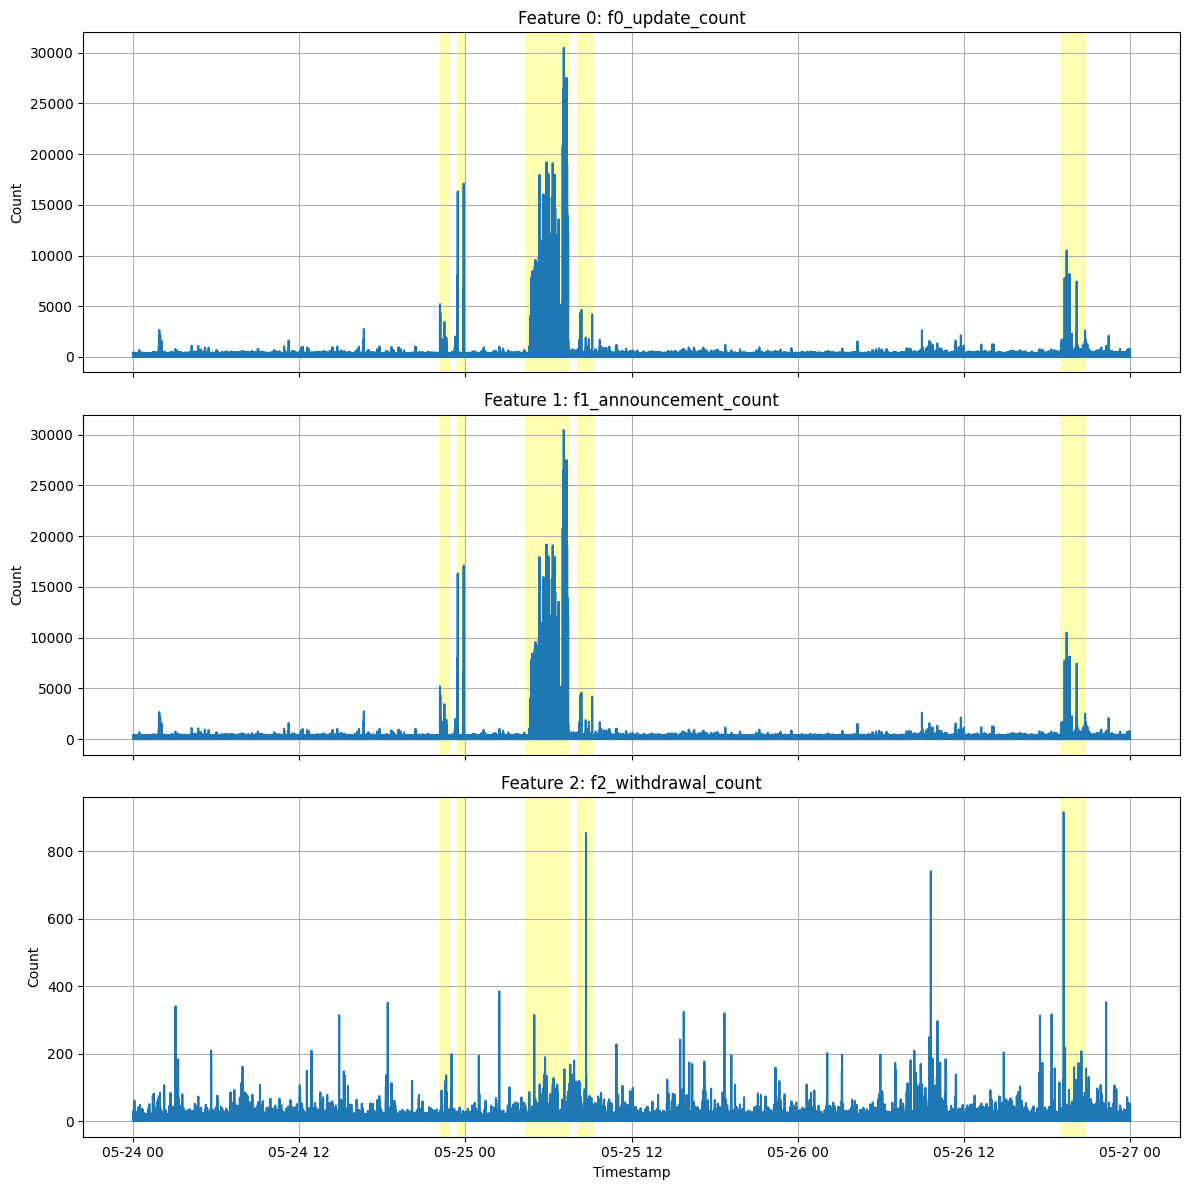

In [3]:
# Plotting
# fig, axs = plt.subplots(len(merged_df.columns) - 1, 1, figsize=(12, 12), sharex=True)
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot each feature dynamically and highlight anomaly intervals
for i, (col, ax) in enumerate(zip(merged_df.columns[1:], axs)):  # Skip 'timestamp'
    ax.plot(merged_df['timestamp'], merged_df[col])
    ax.set_title(f"Feature {i}: {col}")
    ax.set_ylabel("Count")
    ax.grid(True)
    
    # Add background highlights for anomalies
    for start, end in anomaly_intervals:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='yellow', alpha=0.3)

# Add xlabel to the last subplot
axs[-1].set_xlabel("Timestamp")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Median Absolute Deviation

### Simple MAD

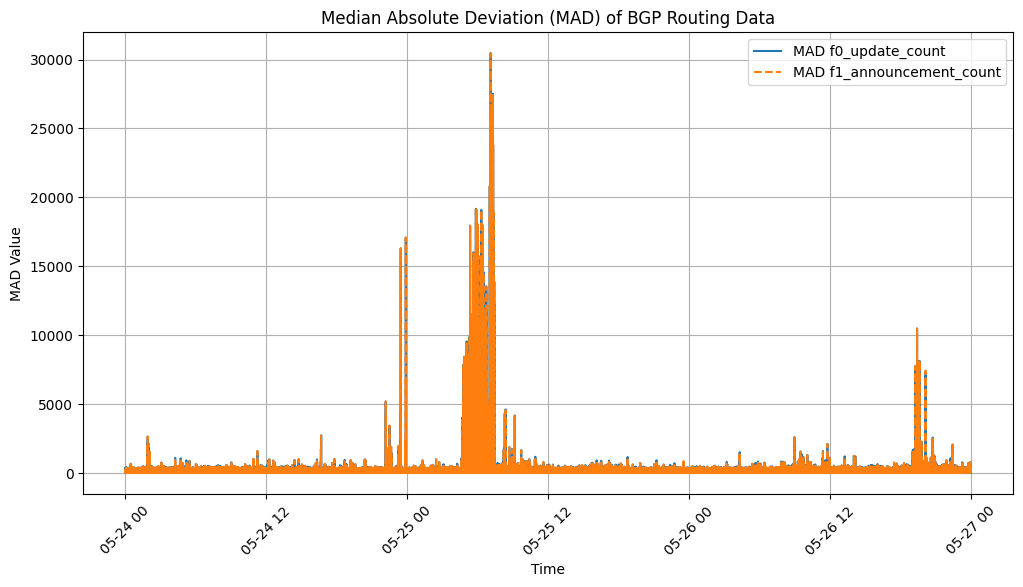

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming merged_df is already loaded
# Convert timestamp to datetime if not already
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Compute the median
median_f0 = merged_df['f0_update_count'].median()
median_f1 = merged_df['f1_announcement_count'].median()

# Compute MAD
mad_f0 = np.median(np.abs(merged_df['f0_update_count'] - median_f0))
mad_f1 = np.median(np.abs(merged_df['f1_announcement_count'] - median_f1))

# Plot MAD over time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['timestamp'], np.abs(merged_df['f0_update_count'] - median_f0), label='MAD f0_update_count')
plt.plot(merged_df['timestamp'], np.abs(merged_df['f1_announcement_count'] - median_f1), label='MAD f1_announcement_count', linestyle='dashed')

plt.xlabel("Time")
plt.ylabel("MAD Value")
plt.title("Median Absolute Deviation (MAD) of BGP Routing Data")
plt.legend()
plt.xticks(rotation=45)
plt.grid()

plt.show()


### Rolling MAD

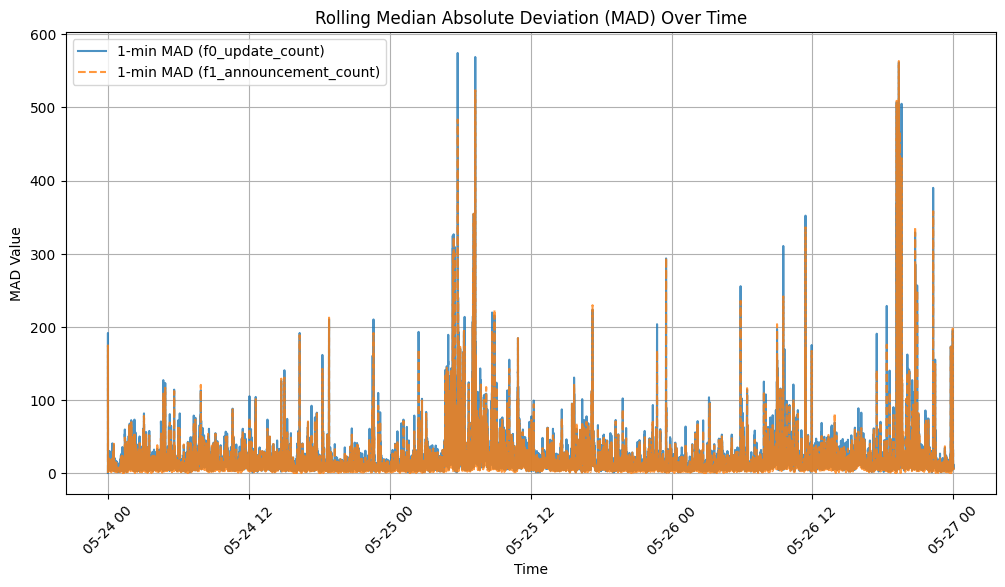

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure timestamp is in datetime format
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Define rolling MAD function
def rolling_mad(series, window):
    return series.rolling(window, min_periods=1).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)

# Define window sizes
window_1min = 10   # 1-minute rolling MAD (10 rows)
window_5min = 50   # 5-minute rolling MAD (50 rows)

# Compute rolling MAD
merged_df['MAD_f0_1min'] = rolling_mad(merged_df['f0_update_count'], window_1min)
merged_df['MAD_f1_1min'] = rolling_mad(merged_df['f1_announcement_count'], window_1min)
merged_df['MAD_f0_5min'] = rolling_mad(merged_df['f0_update_count'], window_5min)
merged_df['MAD_f1_5min'] = rolling_mad(merged_df['f1_announcement_count'], window_5min)

# Plot rolling MAD
plt.figure(figsize=(12, 6))

plt.plot(merged_df['timestamp'], merged_df['MAD_f0_1min'], label="1-min MAD (f0_update_count)", alpha=0.8)
plt.plot(merged_df['timestamp'], merged_df['MAD_f1_1min'], label="1-min MAD (f1_announcement_count)", linestyle="dashed", alpha=0.8)
#plt.plot(merged_df['timestamp'], merged_df['MAD_f0_5min'], label="5-min MAD (f0_update_count)", alpha=0.6)
#plt.plot(merged_df['timestamp'], merged_df['MAD_f1_5min'], label="5-min MAD (f1_announcement_count)", linestyle="dashed", alpha=0.6)

plt.xlabel("Time")
plt.ylabel("MAD Value")
plt.title("Rolling Median Absolute Deviation (MAD) Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid()

plt.show()


## Labeling

            timestamp  mad_f0  mad_f1  anomaly
0 2005-05-24 00:00:09   370.0   340.0        0
1 2005-05-24 00:00:15    13.0     9.0        0
2 2005-05-24 00:00:21    16.0    11.0        0
3 2005-05-24 00:00:27     3.0     6.0        0
4 2005-05-24 00:00:33    41.0    43.0        0
Number of anomalies: 481
Number of non-anomalies: 42718


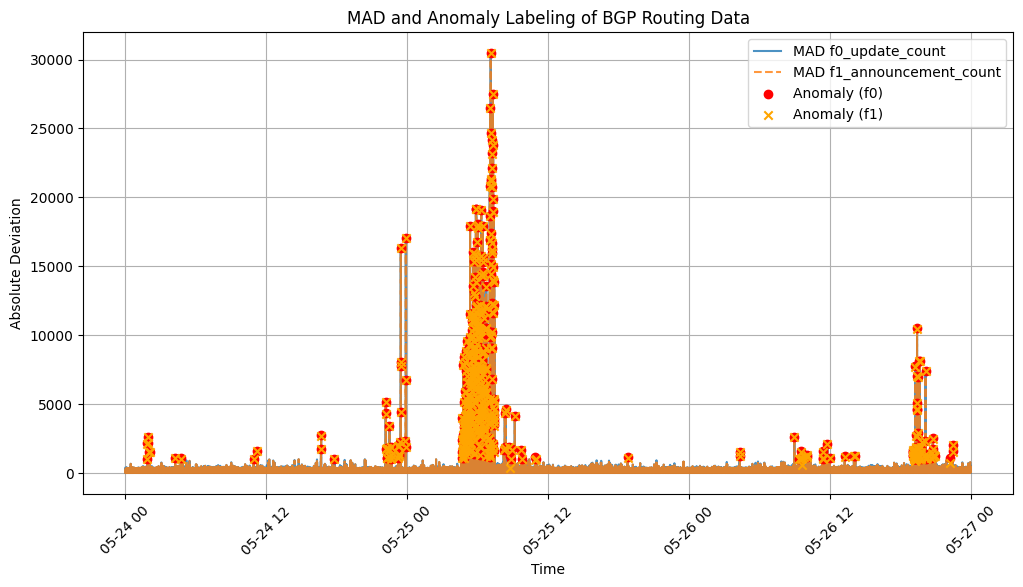

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming merged_df is already loaded and looks similar to:
#   timestamp                f0_update_count   f1_announcement_count
#   2005-05-24 00:00:09      391               354
#   2005-05-24 00:00:15      8                 5
#   ... and so on

# Convert timestamp to datetime if not already
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Compute the overall medians for each metric
median_f0 = merged_df['f0_update_count'].median()
median_f1 = merged_df['f1_announcement_count'].median()

# Calculate the absolute deviation from the median for each interval
merged_df['mad_f0'] = np.abs(merged_df['f0_update_count'] - median_f0)
merged_df['mad_f1'] = np.abs(merged_df['f1_announcement_count'] - median_f1)

# Label the data: if either absolute deviation exceeds 500, label it as an anomaly (1),
# otherwise label it as normal (0)
merged_df['anomaly'] = np.where((merged_df['mad_f0'] > 1000) | (merged_df['mad_f1'] > 1000), 1, 0)

# Optionally, print a few rows to inspect the new columns
print(merged_df[['timestamp', 'mad_f0', 'mad_f1', 'anomaly']].head())

# anomaly counts
count_anomalies = len(merged_df[merged_df['anomaly'] == 1])
print("Number of anomalies:", count_anomalies)

count_anomalies = len(merged_df[merged_df['anomaly'] == 0])
print("Number of non-anomalies:", count_anomalies)



# Plotting the absolute deviations along with anomaly markers
plt.figure(figsize=(12, 6))
plt.plot(merged_df['timestamp'], merged_df['mad_f0'], label='MAD f0_update_count', alpha=0.8)
plt.plot(merged_df['timestamp'], merged_df['mad_f1'], label='MAD f1_announcement_count', linestyle='dashed', alpha=0.8)

# Highlight the intervals flagged as anomalies
anomaly_points = merged_df[merged_df['anomaly'] == 1]
plt.scatter(anomaly_points['timestamp'], anomaly_points['mad_f0'], color='red', label='Anomaly (f0)', zorder=5)
plt.scatter(anomaly_points['timestamp'], anomaly_points['mad_f1'], color='orange', label='Anomaly (f1)', marker='x', zorder=5)

plt.xlabel("Time")
plt.ylabel("Absolute Deviation")
plt.title("MAD and Anomaly Labeling of BGP Routing Data")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Logistic Regressor

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Make sure the timestamp column is in datetime format (if needed)
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Define the feature columns and the target variable.
# Here we're using the raw counts as features.
X = merged_df[['f0_update_count', 'f1_announcement_count']]
y = merged_df['anomaly']  # This column was created earlier to label anomalies

# Split the data: 75% training and 25% validation.
# Using stratify=y will help maintain the anomaly class ratio in both splits.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Create and train the logistic regression model.
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

# Make predictions on the validation set.
y_pred = logreg.predict(X_val)

# Evaluate the model performance.
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Accuracy: 1.0

Confusion Matrix:
[[10680     0]
 [    0   120]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10680
           1       1.00      1.00      1.00       120

    accuracy                           1.00     10800
   macro avg       1.00      1.00      1.00     10800
weighted avg       1.00      1.00      1.00     10800



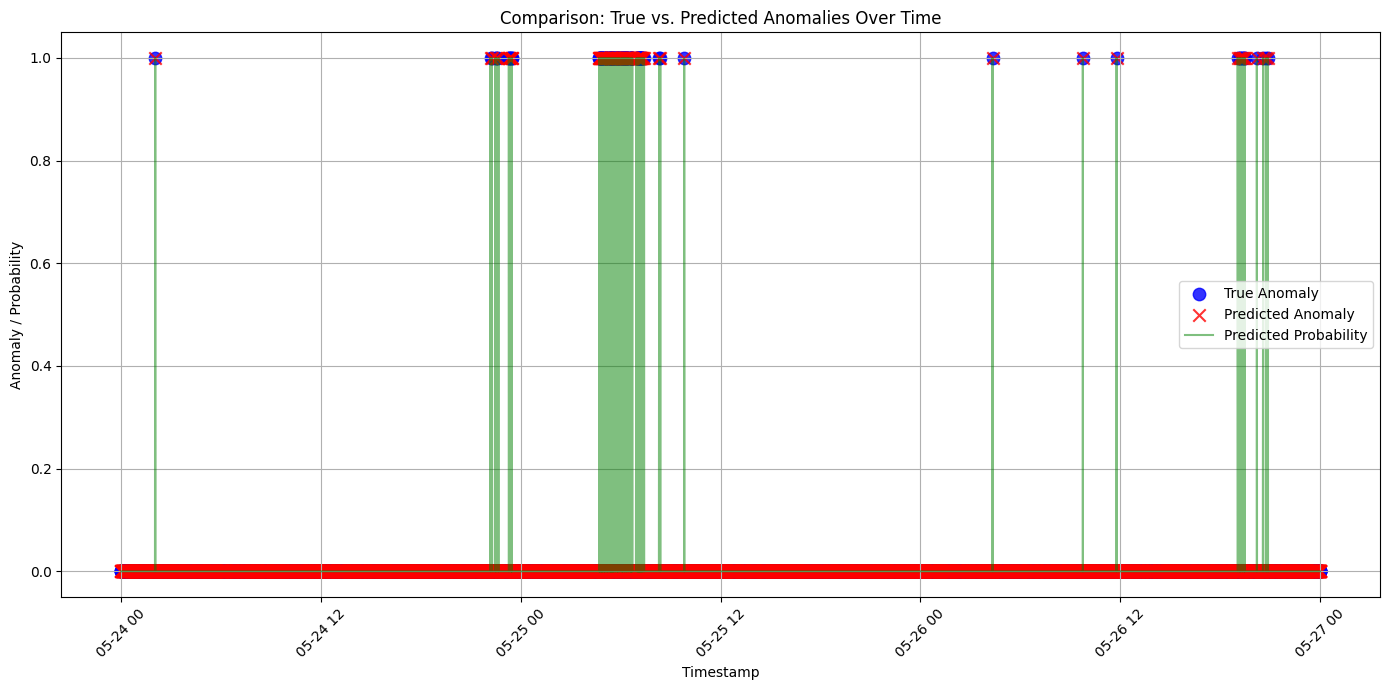

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Assuming previous logistic regression training code has been run ---
# For reference:
# X = merged_df[['f0_update_count', 'f1_announcement_count']]
# y = merged_df['anomaly']
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
# logreg = LogisticRegression(random_state=42, max_iter=1000)
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_val)

# Optionally, obtain predicted probabilities for class 1 (anomaly)
y_pred_proba = logreg.predict_proba(X_val)[:, 1]

# Create a DataFrame for the validation set
# Note: we assume that the indices in X_val match those in merged_df
val_df = X_val.copy()
# Get the timestamp for each row in the validation set
val_df['timestamp'] = merged_df.loc[X_val.index, 'timestamp']
# Add true and predicted anomaly labels
val_df['true_anomaly'] = y_val
val_df['predicted_anomaly'] = y_pred
# Add the predicted probability (for anomaly, class 1)
val_df['predicted_probability'] = y_pred_proba

# Sort the validation DataFrame by timestamp so that the time series is in order
val_df = val_df.sort_values(by='timestamp')

# --- Plotting ---
plt.figure(figsize=(14, 7))

# Plot the true anomaly labels (0 or 1) as blue circles
plt.scatter(val_df['timestamp'], val_df['true_anomaly'],
            color='blue', label='True Anomaly', marker='o', s=80, alpha=0.8)

# Plot the predicted anomaly labels as red crosses
plt.scatter(val_df['timestamp'], val_df['predicted_anomaly'],
            color='red', label='Predicted Anomaly', marker='x', s=80, alpha=0.8)

# Optionally, plot the predicted probability as a green line (values between 0 and 1)
plt.plot(val_df['timestamp'], val_df['predicted_probability'],
         color='green', label='Predicted Probability', alpha=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Anomaly / Probability")
plt.title("Comparison: True vs. Predicted Anomalies Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### Clustering intervals

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure the timestamp is in datetime format
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Compute the medians for each count (for later MAD calculation)
median_f0 = merged_df['f0_update_count'].median()
median_f1 = merged_df['f1_announcement_count'].median()

# Calculate the MAD for each feature (absolute deviation from the median)
merged_df['mad_f0'] = np.abs(merged_df['f0_update_count'] - median_f0)
merged_df['mad_f1'] = np.abs(merged_df['f1_announcement_count'] - median_f1)

# Combine the two MAD values into a single metric (you can choose a different combination if desired)
merged_df['mad'] = (merged_df['mad_f0'] + merged_df['mad_f1']) / 2

# Define your threshold for the average MAD in an interval
threshold = 100  # adjust this value as needed

# Group the data into 1-minute intervals.
# For each group, if the average MAD exceeds the threshold, assign a label of 1 (anomaly) to all rows in that group; otherwise, assign 0.
merged_df['anomaly'] = merged_df.groupby(pd.Grouper(key='timestamp', freq='10min'))['mad'] \
                                .transform(lambda x: 1 if x.mean() > threshold else 0)

# (Optional) Inspect the first few rows to see the new columns
print(merged_df[['timestamp', 'mad', 'anomaly']].head(20))


             timestamp    mad  anomaly
0  2005-05-24 00:00:09  355.0        0
1  2005-05-24 00:00:15   11.0        0
2  2005-05-24 00:00:21   13.5        0
3  2005-05-24 00:00:27    4.5        0
4  2005-05-24 00:00:33   42.0        0
5  2005-05-24 00:00:39    5.0        0
6  2005-05-24 00:00:45   13.5        0
7  2005-05-24 00:00:51    7.0        0
8  2005-05-24 00:00:57   14.0        0
9  2005-05-24 00:01:03  319.0        0
10 2005-05-24 00:01:09   18.0        0
11 2005-05-24 00:01:15    4.0        0
12 2005-05-24 00:01:21    2.0        0
13 2005-05-24 00:01:27   80.0        0
14 2005-05-24 00:01:33   10.5        0
15 2005-05-24 00:01:39    4.0        0
16 2005-05-24 00:01:45   14.5        0
17 2005-05-24 00:01:51   14.5        0
18 2005-05-24 00:01:57  349.0        0
19 2005-05-24 00:02:03   25.5        0


Accuracy: 0.8807407407407407
Confusion Matrix:
 [[9391    9]
 [1279  121]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      9400
           1       0.93      0.09      0.16      1400

    accuracy                           0.88     10800
   macro avg       0.91      0.54      0.55     10800
weighted avg       0.89      0.88      0.84     10800



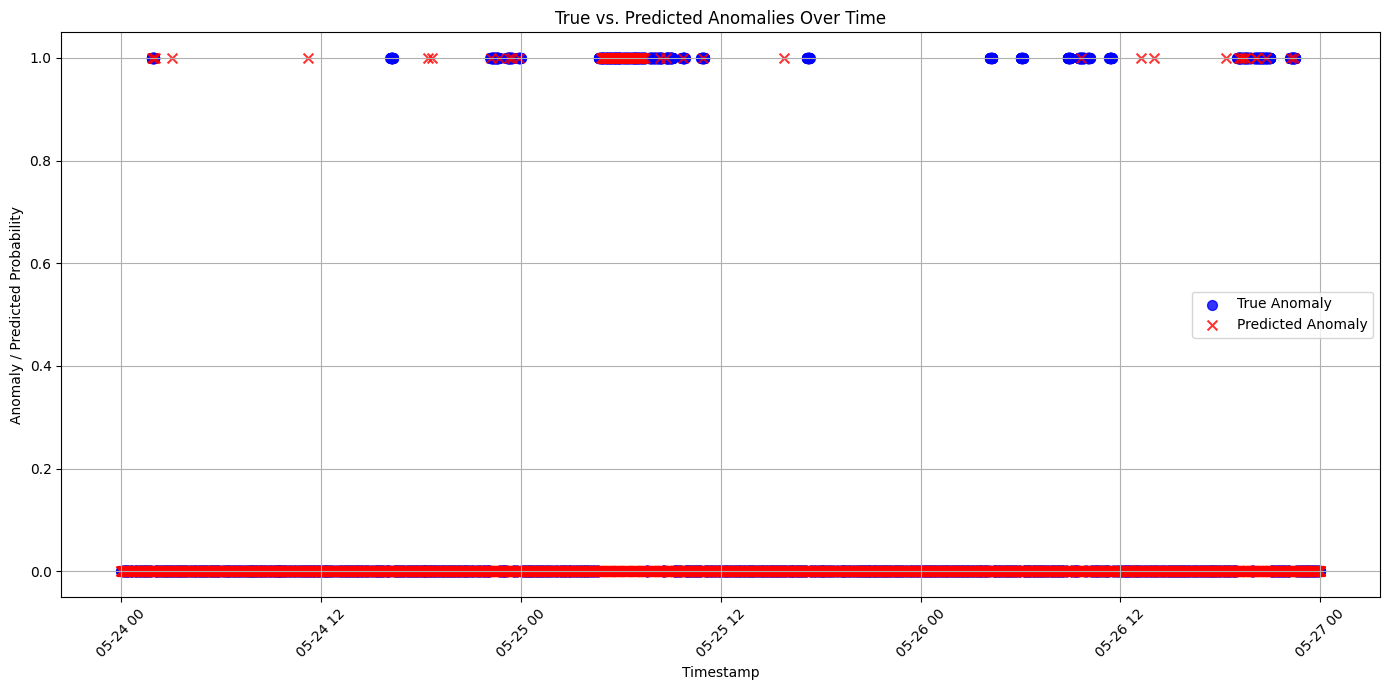

In [10]:
# ---------------------------
# 3. TRAIN/VALIDATION SPLIT AND MODEL TRAINING
# ---------------------------

# Choose the features you want to use for the prediction.
# Here we use the raw counts from the BGP data.
features = ['f0_update_count', 'f1_announcement_count']
X = merged_df[features]
y = merged_df['anomaly']

# Split the data into 75% training and 25% validation.
# We use stratification to maintain the same ratio of anomaly classes in both splits.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Create a logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))



# ---------------------------
# 3. PLOTTING TRUE VS. PREDICTED ANOMALIES
# ---------------------------

# Create a DataFrame for the validation results.
# We use the index from X_val to retrieve the corresponding timestamps.
val_df = X_val.copy()
val_df['timestamp'] = merged_df.loc[X_val.index, 'timestamp']
val_df['true_anomaly'] = y_val
val_df['predicted_anomaly'] = y_pred
val_df['predicted_probability'] = y_pred_proba

# Sort by timestamp for a proper time series plot.
val_df = val_df.sort_values(by='timestamp')

# Create the plot
plt.figure(figsize=(14, 7))

# Plot true anomaly labels as blue circles
plt.scatter(val_df['timestamp'], val_df['true_anomaly'], 
            color='blue', label='True Anomaly', marker='o', s=50, alpha=0.8)

# Plot predicted anomaly labels as red crosses
plt.scatter(val_df['timestamp'], val_df['predicted_anomaly'], 
            color='red', label='Predicted Anomaly', marker='x', s=50, alpha=0.8)

# Plot the predicted probability as a green line (values range between 0 and 1)
#plt.plot(val_df['timestamp'], val_df['predicted_probability'], 
#         color='green', label='Predicted Probability', alpha=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Anomaly / Predicted Probability")
plt.title("True vs. Predicted Anomalies Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Downsampling

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming 'merged_df' is your DataFrame and it already includes the 'anomaly' column
# (with 0 for the majority class and 1 for the minority/anomaly class)

# ----------------------------------------
# 1. Downsample the Majority Class (0)
# ----------------------------------------

# Separate majority and minority classes
df_majority = merged_df[merged_df['anomaly'] == 0]
df_minority = merged_df[merged_df['anomaly'] == 1]

# Check the class counts before downsampling
print("Before downsampling:")
print("Majority class (0):", len(df_majority))
print("Minority class (1):", len(df_minority))

# Downsample the majority class to have the same number of samples as the minority class
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)

# Combine the downsampled majority class with the minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Optional: Shuffle the resulting DataFrame
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the class counts after downsampling
print("\nAfter downsampling:")
print(df_downsampled['anomaly'].value_counts())

# ----------------------------------------
# 2. Train the Logistic Regression Model on the Downsampled Data
# ----------------------------------------

# Select features and target
features = ['f0_update_count', 'f1_announcement_count']  # Adjust or add more features as needed
X = df_downsampled[features]
y = df_downsampled['anomaly']

# Split into training and validation sets (75% training, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Create and train the logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))


Before downsampling:
Majority class (0): 37599
Minority class (1): 5600

After downsampling:
anomaly
0    5600
1    5600
Name: count, dtype: int64

Model Evaluation:
Accuracy: 0.5621428571428572
Confusion Matrix:
 [[1162  238]
 [ 988  412]]
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.83      0.65      1400
           1       0.63      0.29      0.40      1400

    accuracy                           0.56      2800
   macro avg       0.59      0.56      0.53      2800
weighted avg       0.59      0.56      0.53      2800



## Downsampled and Random Forest

Before downsampling:
Majority class (0): 37599
Minority class (1): 5600

After downsampling:
anomaly
0    22400
1     5600
Name: count, dtype: int64

Random Forest Model Evaluation:
Accuracy: 0.7974285714285714
Confusion Matrix:
 [[5335  265]
 [1153  247]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88      5600
           1       0.48      0.18      0.26      1400

    accuracy                           0.80      7000
   macro avg       0.65      0.56      0.57      7000
weighted avg       0.75      0.80      0.76      7000



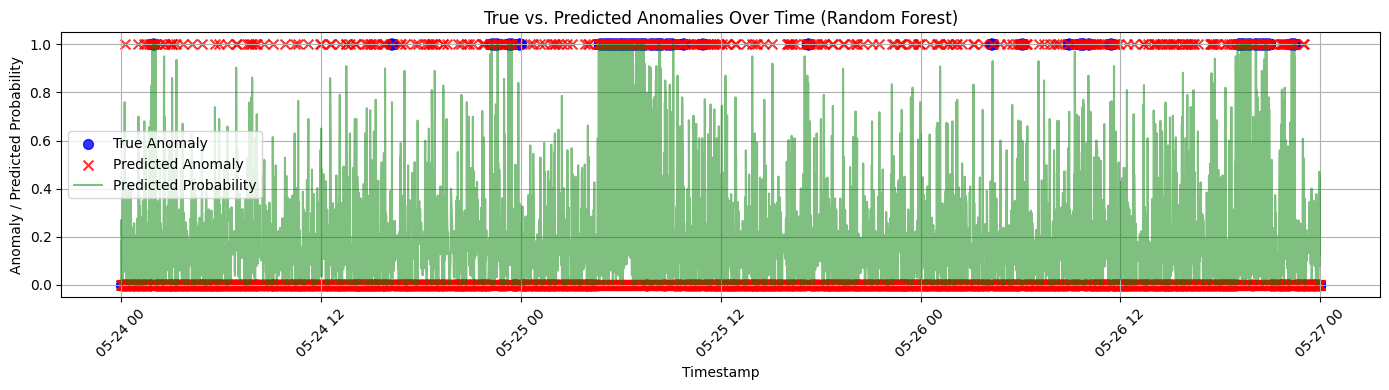

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assume merged_df already exists and includes 'timestamp' and 'anomaly' columns.

# ----------------------------------------
# 1. Separate the Classes
# ----------------------------------------
df_majority = merged_df[merged_df['anomaly'] == 0]
df_minority = merged_df[merged_df['anomaly'] == 1]

print("Before downsampling:")
print("Majority class (0):", len(df_majority))
print("Minority class (1):", len(df_minority))

# ----------------------------------------
# 2. Downsampling Control
# ----------------------------------------

# Using a ratio relative to the minority class
desired_ratio = 4  # For equal number of majority samples as minority samples.
num_minority = len(df_minority)
num_majority_to_keep = int(desired_ratio * num_minority)
df_majority_downsampled = df_majority.sample(n=num_majority_to_keep, random_state=42)

# Combine the downsampled majority with the minority class and shuffle
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nAfter downsampling:")
print(df_downsampled['anomaly'].value_counts())

# ----------------------------------------
# 3. Train the Random Forest Classifier
# ----------------------------------------
features = ['f0_update_count', 'f1_announcement_count']
X = df_downsampled[features]
y = df_downsampled['anomaly']

# Split data into training (75%) and validation (25%) sets.
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)
y_pred_proba = rf_model.predict_proba(X_val)[:, 1]

print("\nRandom Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

# ----------------------------------------
# 4. Plot True vs. Predicted Anomalies Over Time
# ----------------------------------------
# Create a DataFrame for validation results.
val_df = X_val.copy()
val_df['timestamp'] = df_downsampled.loc[X_val.index, 'timestamp']
val_df['true_anomaly'] = y_val
val_df['predicted_anomaly'] = y_pred
val_df['predicted_probability'] = y_pred_proba

# Sort by timestamp
val_df = val_df.sort_values(by='timestamp')

plt.figure(figsize=(14, 4))
plt.scatter(val_df['timestamp'], val_df['true_anomaly'],
            color='blue', label='True Anomaly', marker='o', s=50, alpha=0.8)
plt.scatter(val_df['timestamp'], val_df['predicted_anomaly'],
            color='red', label='Predicted Anomaly', marker='x', s=50, alpha=0.8)
plt.plot(val_df['timestamp'], val_df['predicted_probability'],
         color='green', label='Predicted Probability', alpha=0.5)

plt.xlabel("Timestamp")
plt.ylabel("Anomaly / Predicted Probability")
plt.title("True vs. Predicted Anomalies Over Time (Random Forest)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
